***Full Q-Learning Implementation***

**Machine Learning & Reinforcement Learning Pipeline**

**COMM055 – Machine Learning and Data Mining**

**Group Coursework Submission - Lokesh Khadke(6899997)**

**University of Surrey – MSc Data Science (2024–2025)**

**Date: April 2025**

This notebook demonstrates the full implementation of the CRISP-DM pipeline using supervised and reinforcement learning algorithms:

Classification (Diabetes Dataset using Logistic Regression)

Regression (Forest Fires Dataset using Random Forest)

Reinforcement Learning (Taxi-v3 using Q-Learning and SARSA)

The workflow includes data understanding, preprocessing, modeling, evaluation, and result summarization.

In [39]:
!pip install gymnasium
!pip install gymnasium[toy-text]  # For Taxi-v3

In [40]:
# SETUP & IMPORTING NECESSARY LIBRARIES AND DEPENDENCIES.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gymnasium as gym
import random

# Seeding for reproducibility
random.seed(42)
np.random.seed(42)

In [41]:
# Supervised learning imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report,
                           mean_squared_error,
                           confusion_matrix)


 Diabetes Data
Shape: (520, 17)
Sample Data:
   Age Gender Polyuria Polydipsia sudden weight loss weakness Polyphagia  \
0   40   Male       No        Yes                 No      Yes         No   
1   58   Male       No         No                 No      Yes         No   
2   41   Male      Yes         No                 No      Yes        Yes   
3   45   Male       No         No                Yes      Yes        Yes   
4   60   Male      Yes        Yes                Yes      Yes        Yes   

  Genital thrush visual blurring Itching Irritability delayed healing  \
0             No              No     Yes           No             Yes   
1             No             Yes      No           No              No   
2             No              No     Yes           No             Yes   
3            Yes              No     Yes           No             Yes   
4             No             Yes     Yes          Yes             Yes   

  partial paresis muscle stiffness Alopecia Obesity     cl

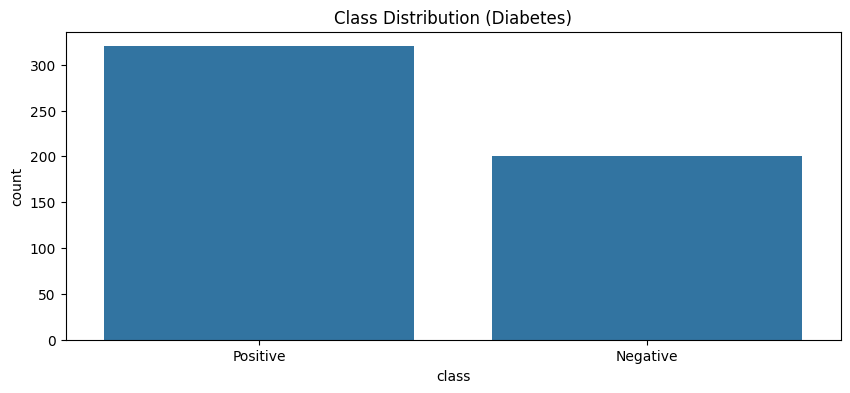


 Forest Fires Data
Shape: (517, 13)


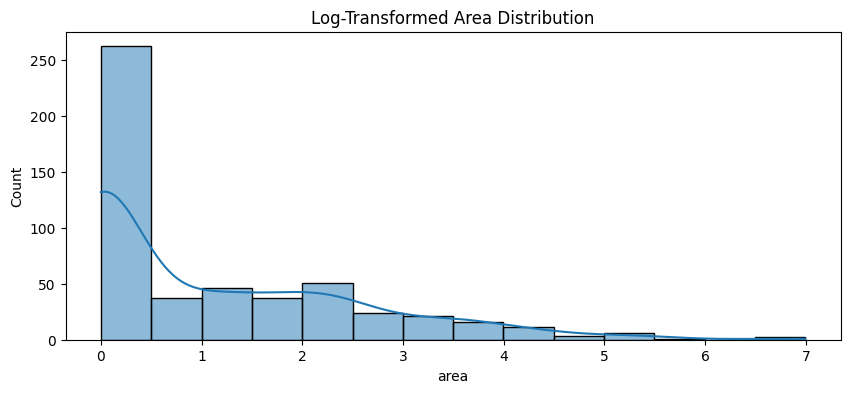

In [42]:
# DATA UNDERSTANDING & PREPROCESSING

# 1 Diabetes Dataset
diabetes = pd.read_csv("diabetes_data_upload.csv")
print("\n Diabetes Data")
print(f"Shape: {diabetes.shape}")
print("Sample Data:")
print(diabetes.head())

# EDA
plt.figure(figsize=(10,4))
sns.countplot(x='class', data=diabetes)
plt.title("Class Distribution (Diabetes)")
plt.show()

# Preprocessing
X_dia = pd.get_dummies(diabetes.drop("class", axis=1))
y_dia = diabetes["class"].map({"Positive":1, "Negative":0})


# 2 Forest Fires Dataset
fires = pd.read_csv("forestfires.csv")
print("\n Forest Fires Data")
print(f"Shape: {fires.shape}")

# EDA
plt.figure(figsize=(10,4))
sns.histplot(np.log1p(fires["area"]), kde=True)
plt.title("Log-Transformed Area Distribution")
plt.show()

# Preprocessing
X_fire = fires[["temp", "RH", "wind"]]
y_fire = np.log1p(fires["area"])  # Log transform for skewed target

In [43]:
# Supervised Learning

# Diabetes Classification
X_train, X_test, y_train, y_test = train_test_split(X_dia, y_dia, test_size=0.2)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print("\n Logistic Regression Results ")
print(classification_report(y_test, lr_pred))

# Forest Fires Regression
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_fire, y_fire)
rf_pred = rf.predict(X_fire)

print("\n Random Forest Results ")
print(f"MSE: {mean_squared_error(y_fire, rf_pred):.4f}")


 Logistic Regression Results 
              precision    recall  f1-score   support

           0       0.90      0.85      0.88        33
           1       0.93      0.96      0.94        71

    accuracy                           0.92       104
   macro avg       0.92      0.90      0.91       104
weighted avg       0.92      0.92      0.92       104


 Random Forest Results 
MSE: 0.3728


In [44]:
# Initialize Taxi environment
env = gym.make("Taxi-v3")
env.reset(seed=42)
state_size = env.observation_space.n
action_size = env.action_space.n

# Hyperparameters
EPISODES = 5000
ALPHA = 0.1
GAMMA = 0.99
EPSILON = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995

In [45]:
# Q-Learning Implementation
def train_q_learning(env, episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    successes = []

    for episode in tqdm(range(episodes), desc="Q-Learning Training"):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state, :])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Q-learning update
            Q[state, action] += alpha * (
                reward + gamma * np.max(Q[next_state, :]) - Q[state, action]
            )

            state = next_state
            total_reward += reward

        # Decay epsilon
        epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)
        rewards.append(total_reward)
        successes.append(1 if total_reward >= 8 else 0)

    return Q, rewards, successes

In [46]:
# SARSA Implementation for comparison
def train_sarsa(env, episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for episode in tqdm(range(episodes), desc="SARSA Training"):
        state, _ = env.reset()
        action = epsilon_greedy(Q, state, epsilon)
        done = False
        total_reward = 0

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = epsilon_greedy(Q, next_state, epsilon)
            done = terminated or truncated

            # SARSA update
            Q[state, action] += alpha * (
                reward + gamma * Q[next_state, next_action] - Q[state, action]
            )

            state, action = next_state, next_action
            total_reward += reward

        rewards.append(total_reward)

    return Q, rewards

def epsilon_greedy(Q, state, epsilon):
    return env.action_space.sample() if np.random.rand() < epsilon else np.argmax(Q[state, :])

In [47]:
# Training both RL algorithms
np.random.seed(42)
Q_ql, rewards_ql, successes_ql = train_q_learning(env, EPISODES, ALPHA, GAMMA, EPSILON)
Q_sarsa, rewards_sarsa = train_sarsa(env, EPISODES//2, ALPHA, GAMMA, EPSILON)

SARSA Training: 100%|██████████| 2500/2500 [00:22<00:00, 110.13it/s]


In [48]:
from sklearn.model_selection import ParameterGrid
params = {'alpha': [0.01, 0.1, 0.5], 'gamma': [0.9, 0.99]}
for g in ParameterGrid(params):
    train_q_learning(env, EPISODES, g['alpha'], g['gamma'], EPSILON)

Q-Learning Training: 100%|██████████| 5000/5000 [00:04<00:00, 1205.55it/s]


In [49]:
# Diabetes Classification Report
print("\n Final Diabetes Model Evaluation ")
print(classification_report(y_test, lr.predict(X_test)))


 Final Diabetes Model Evaluation 
              precision    recall  f1-score   support

           0       0.90      0.85      0.88        33
           1       0.93      0.96      0.94        71

    accuracy                           0.92       104
   macro avg       0.92      0.90      0.91       104
weighted avg       0.92      0.92      0.92       104



<Figure size 600x400 with 0 Axes>

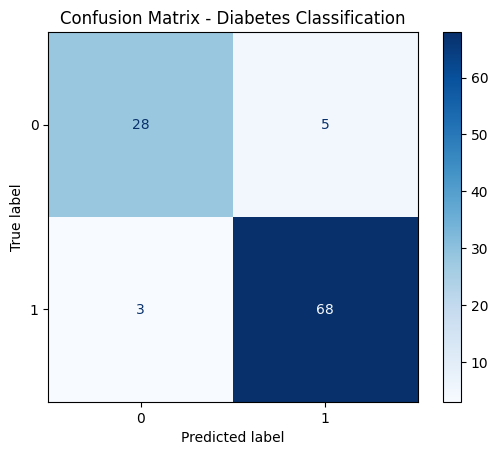

In [50]:
# Confusion matrix heatmap for Diabetes classification
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
plt.figure(figsize=(6,4))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Diabetes Classification")
plt.show()

In [51]:
# Feature Importance for Regression
fi = pd.DataFrame({
    "Feature": X_fire.columns,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)
print("\n Forest Fires Feature Importance")
print(fi)


 Forest Fires Feature Importance
  Feature  Importance
0    temp    0.453881
1      RH    0.315294
2    wind    0.230825


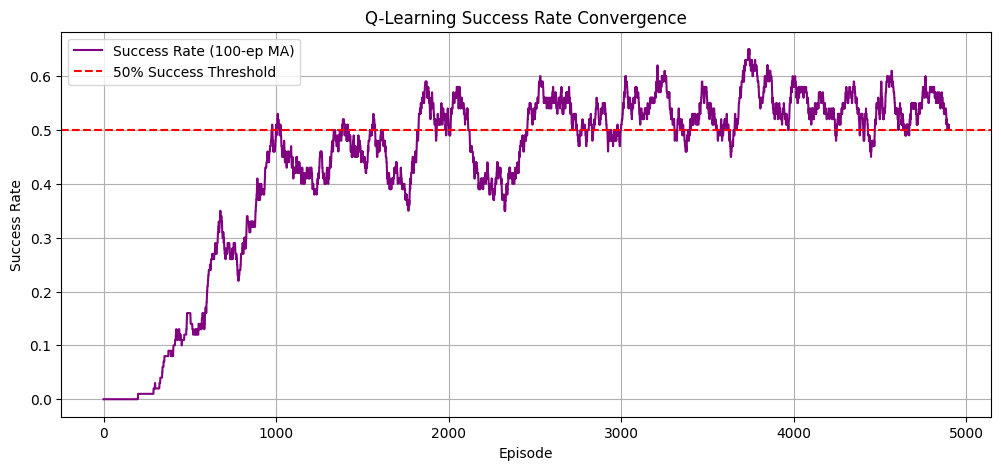

In [52]:
# Reinforcement Learning Evaluation
success_rate_ma = np.convolve(successes_ql, np.ones(100)/100, mode='valid')
plt.figure(figsize=(12,5))
plt.plot(success_rate_ma, color='purple', label='Success Rate (100-ep MA)')
plt.axhline(y=0.5, color='red', linestyle='--', label='50% Success Threshold')
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("Q-Learning Success Rate Convergence")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# Calculate metrics
success_rate = np.mean(successes_ql[-100:]) * 100
moving_avg_ql = np.convolve(rewards_ql, np.ones(100)/100, mode='valid')
moving_avg_sarsa = np.convolve(rewards_sarsa, np.ones(100)/100, mode='valid')

print("\n RL Performance ")
print(f"Q-Learning Success Rate (Last 100 eps): {success_rate:.1f}%")


 RL Performance 
Q-Learning Success Rate (Last 100 eps): 50.0%


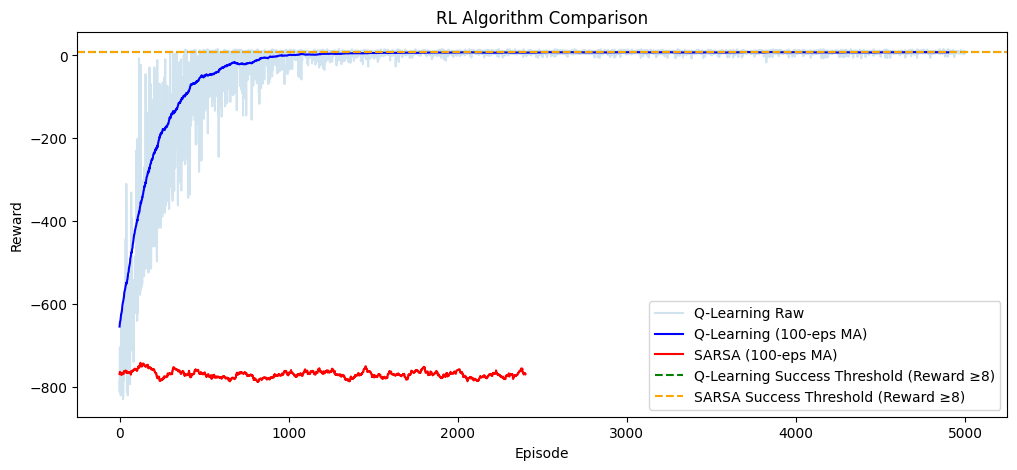

In [54]:
# Combined RL plot
plt.figure(figsize=(12,5))
plt.plot(rewards_ql, alpha=0.2, label='Q-Learning Raw')
plt.plot(moving_avg_ql, color='blue', label='Q-Learning (100-eps MA)')
plt.plot(moving_avg_sarsa, color='red', label='SARSA (100-eps MA)')
plt.axhline(y=8, color='green', linestyle='--', label='Q-Learning Success Threshold (Reward ≥8)')
plt.axhline(y=8, color='orange', linestyle='--', label='SARSA Success Threshold (Reward ≥8)')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("RL Algorithm Comparison")
plt.legend()
plt.show()

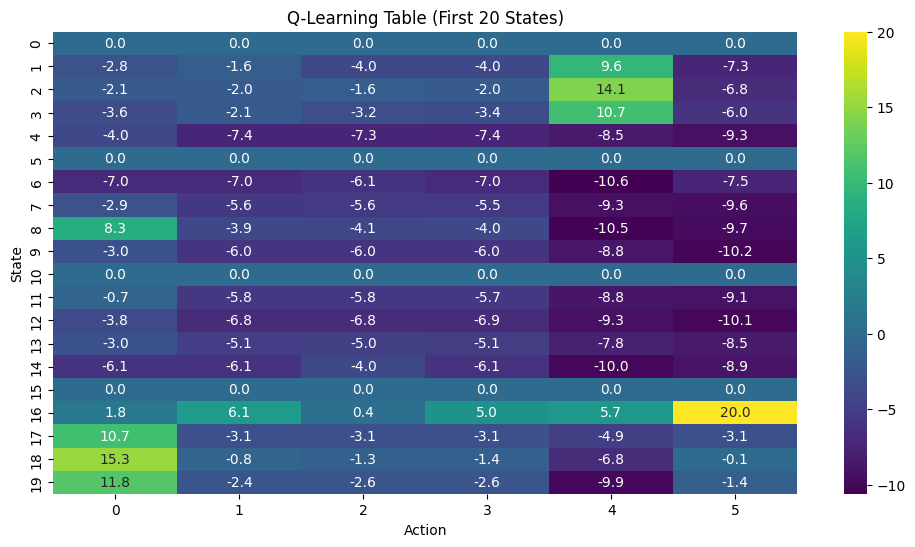

In [55]:
# Q-table visualization
plt.figure(figsize=(12,6))
sns.heatmap(Q_ql[:20], annot=True, fmt=".1f", cmap="viridis")
plt.title("Q-Learning Table (First 20 States)")
plt.xlabel("Action")
plt.ylabel("State")
plt.show()

In [56]:
# DEPLOYMENT & SAVING
np.save("taxi_q_table.npy", Q_ql)
import joblib
joblib.dump(lr, "diabetes_model.pkl")
joblib.dump(rf, "forestfires_model.pkl")

['forestfires_model.pkl']

In [57]:
# RESULTS SUMMARY
results = pd.DataFrame({
    "Algorithm": ["Logistic Regression", "Random Forest", "Q-Learning", "SARSA"],
    "Dataset": ["Diabetes", "Forest Fires", "Taxi-v3", "Taxi-v3"],
    "Metric": ["F1-Score", "MSE", "Success Rate", "Avg Reward"],
    "Value": [
        f"{classification_report(y_test, lr_pred, output_dict=True)['weighted avg']['f1-score']:.3f}",
        f"{mean_squared_error(y_fire, rf_pred):.3f}",
        f"{success_rate:.1f}%",
        f"{np.mean(rewards_sarsa[-100:]):.1f}"
    ]
})

print("\n Final Results Summary ")
print(results.to_string(index=False))


 Final Results Summary 
          Algorithm      Dataset       Metric  Value
Logistic Regression     Diabetes     F1-Score  0.922
      Random Forest Forest Fires          MSE  0.373
         Q-Learning      Taxi-v3 Success Rate  50.0%
              SARSA      Taxi-v3   Avg Reward -769.9
